importing libraries and models

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Importing the Coefficient of determination
from sklearn.metrics import mean_squared_error , r2_score , mean_absolute_error
# Importing Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
# Importing Grid Search & Random Search
from sklearn.model_selection import RandomizedSearchCV
# Importing Optun
import optuna
# Importing training & testing models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

Performing EDA

In [94]:
dataset = pd.read_csv('records.csv')
result = pd.read_csv('results.csv').to_numpy()
X, y = dataset, result.ravel()
print(y.shape)
print(X.shape)
X.describe()

(170,)
(170, 4)


,Animal Products,Cereals - Excluding Beer,Obesity,Vegetal Products
count,170.000000,170.000000,170.000000,170.000000
mean,20.695714,4.376548,18.377647,29.304396
std,8.002713,3.183815,9.862101,8.002369
min,5.018200,0.990800,0.000000,13.098200
25%,14.885800,1.970150,8.200000,23.133050
50%,20.943050,3.306750,20.700000,29.060600
75%,26.866950,5.587600,25.700000,35.117250
max,36.901800,18.376300,45.600000,44.981800


<AxesSubplot:>

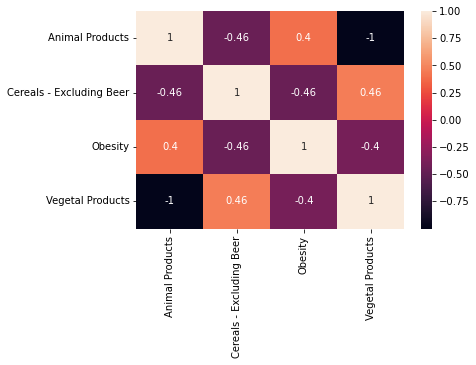

In [95]:
sns.heatmap(X.corr(), annot=True)

Because there is multi-colinearity, we will remove the 4th Col from Data

In [96]:
X = X.iloc[:, 0:3]
print(X.head())

   Animal Products  Cereals - Excluding Beer  Obesity
0          21.6397                    8.0353      4.5
1          32.0002                    2.6734     22.3
2          14.4175                    4.2035     26.6
3          15.3041                    6.5545      6.8
4          27.7033                    3.2153     19.1


Set train and test sizes

In [97]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10)
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

creating the evaluation_model function with the Coefficient of determination

In [98]:
def eval_model(model):
    mean_abs_error=mean_absolute_error(y_test,model.predict(X_test))
    mean_square_error=mean_squared_error(y_test,model.predict(X_test))
    r2_error=r2_score(y_test,model.predict(X_test))

    print(f'Mean absolute error : {mean_abs_error}')
    print(f'Mean squared error : {mean_square_error}')
    print(f'R2 score : {r2_error}')

Gradient Boosting Regressor

In [99]:
params = {
    "n_estimators": 100,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    
}

regr = GradientBoostingRegressor(**params)
regr.fit(X_train, y_train)
# Make predictions using the testing set
y_pred = regr.predict(X_test)
print("Evaluating Gradient Boosting model :")
eval_model(regr)

Evaluating Gradient Boosting model :
Mean absolute error : 0.03068160668462208
Mean squared error : 0.0013843882291135565
R2 score : 0.3541793030822129


Tuning Gradient Boosting with Grid Search

In [100]:
from sklearn.model_selection import GridSearchCV
grid = dict()
grid['n_estimators'] = [50,100,150,200,300]
grid['learning_rate'] = [0.1,1]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['max_depth'] = [1,2,3]

tuning = GridSearchCV(estimator= regr, param_grid = grid , scoring="r2", n_jobs=-1, verbose=1)
tuning.fit(X_train,y_train)

tuning.best_params_,tuning.best_score_

Fitting 5 folds for each of 90 candidates, totalling 450 fits


({'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50, 'subsample': 0.5},
 0.2855888754383537)

Evaluating the model with Grid Search

In [101]:
eval_model(tuning)

Mean absolute error : 0.027496502408258235
Mean squared error : 0.001255820659009203
R2 score : 0.41415640775536255


Tuning Gradient Boosting with Random Search 

In [110]:
grid = dict()
grid['n_estimators'] = [50,500,100,150,200,250,300,350,400,450,]
grid['learning_rate'] = [0.1,0.2,0.3,0.4,0.4,0.5,0.6]
grid['subsample'] = [0.5,0.3,0.7,0.9,1.2,2.4,1.5]
grid['max_depth'] = [1,2,3,4,5,6,7,8,9,10]

tuning = RandomizedSearchCV(regr, grid , scoring="r2", n_jobs=-1, verbose=1)
tuning.fit(X_train,y_train)

print(tuning.best_params_, "\n", tuning.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'subsample': 0.7, 'n_estimators': 150, 'max_depth': 1, 'learning_rate': 0.2} 
 0.21749041908051528


c:\Users\Ahmed Abdelghani\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [ 0.0478387          nan  0.18543317  0.21749042         nan -0.5380086
  0.03355248         nan  0.01774303 -0.51868915]
  warnings.warn(


Evaluating the model with Random Search

In [111]:
eval_model(tuning)

Mean absolute error : 0.025965509193903016
Mean squared error : 0.001208300121525248
R2 score : 0.43632486165463236


Tuning Gradient Boosting with Optuna

In [119]:
params = {
    "n_estimators": 100,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
}

regr = GradientBoostingRegressor(**params)
regr.fit(X_train, y_train)

def objective(trial):
    x = trial.suggest_float(regr, -10, 10)
    return (x - 2) ** 2


study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params

[I 2022-06-05 22:03:05,785] A new study created in memory with name: no-name-fc74574a-6064-42a9-bd81-f95dae943f71
[I 2022-06-05 22:03:05,825] Trial 0 finished with value: 78.97450065617868 and parameters: {GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5): -6.886759851384456}. Best is trial 0 with value: 78.97450065617868.
[I 2022-06-05 22:03:05,862] Trial 1 finished with value: 9.902476430000267 and parameters: {GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5): 5.146820050463685}. Best is trial 1 with value: 9.902476430000267.
[I 2022-06-05 22:03:05,894] Trial 2 finished with value: 95.55680957299955 and parameters: {GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5): -7.775316341326226}. Best is trial 1 with value: 9.902476430000267.
[I 2022-06-05 22:03:05,933] Trial 3 finished with value: 16.805044185793985 and parameters: {GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_

{GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5): 2.012672250503737}

Evaluating the model with Optuna

In [120]:
eval_model(regr)

Mean absolute error : 0.030693705063438787
Mean squared error : 0.001385605321789984
R2 score : 0.3536115261942172
